C:\Users\matss\AppData\Local\Temp\ipykernel_40812\1264352937.py:72: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = simulator.run(qobj).result()


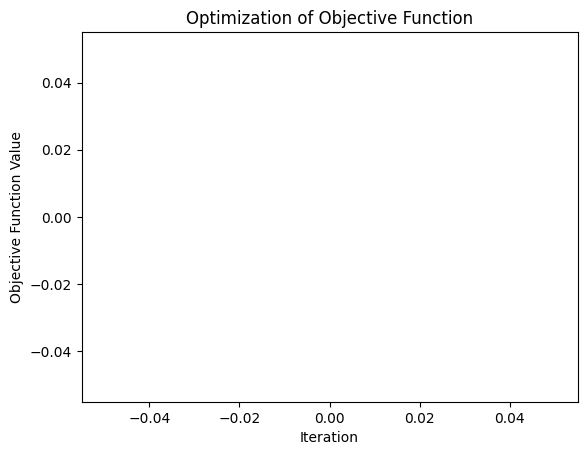

Optimized Parameters: [2.35330497 5.97351416 4.59925358 3.76148219]


In [75]:
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import Aer
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
N = 4  # Number of nodes
n = int(np.ceil(np.log2(N)))  # Number of qubits in the address register
m = 1  # Number of qubits in the embedding register (you can adjust as needed)

gamma = 0.5
alpha = 0.1
delta_theta = 0.01
beta = 0.1
t = 1  # Time parameter for evolution

theta = np.random.rand(N) * 2 * np.pi  # Initialize theta randomly
adj_matrix = np.array([
    [0, 1, 0, 0],
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [0, 0, 1, 0]
])

def quantum_encoder(theta, N, m):
    qc = QuantumCircuit(N + m)
    for i in range(N):
        qc.ry(theta[i], i)
    return qc

def matrix_inverse_evolution(qc, beta, adj_matrix, N, t=1):
    identity = np.eye(N)
    I_minus_betaA = identity - beta * adj_matrix
    
    # Apply Trotter-Suzuki decomposition to approximate e^{-i(I - beta*A)*t}
    for _ in range(t):
        for i in range(N):
            for j in range(N):
                if I_minus_betaA[i][j] != 0:
                    angle = -2 * I_minus_betaA[i][j]
                    qc.rz(angle, j)
    return qc

def hadamard_test(theta, beta, adj_matrix, N, m, t=1):
    qc = QuantumCircuit(1 + N + m)  # 1 ancilla qubit + address and embedding registers
    
    # Prepare the initial state
    qc.h(0)  # Hadamard on the ancilla qubit
    
    # Quantum encoder circuit
    encoder_qc = quantum_encoder(theta, N, m)
    qc = qc.compose(encoder_qc, qubits=range(1, N + m + 1))
    
    # Apply controlled-U (matrix-inverse evolution)
    controlled_U = QuantumCircuit(N + m)
    controlled_U = matrix_inverse_evolution(controlled_U, beta, adj_matrix, N, t)
    qc = qc.compose(controlled_U.control(1), qubits=[0] + list(range(1, N + m + 1)))
    
    # Apply the second Hadamard gate
    qc.h(0)
    
    # Measure the ancilla qubit
    qc.measure_all()
    
    return qc

def estimate_L(theta, adj_matrix, beta, N, m, t):
    qc = hadamard_test(theta, beta, adj_matrix, N, m, t)
    simulator = Aer.get_backend('aer_simulator')
    transpiled_qc = transpile(qc, simulator)
    qobj = assemble(transpiled_qc)
    result = simulator.run(qobj).result()
    counts = result.get_counts()
    
    # Calculate expectation value <psi|U|psi>
    expectation_value = (counts.get('0', 0) - counts.get('1', 0)) / sum(counts.values())
    return expectation_value

def optimize_parameters(theta, adj_matrix, beta, alpha, delta_theta, N, m, t, max_iter=100):
    objective_values = []
    for _ in range(max_iter):
        grad = np.zeros_like(theta)
        for i in range(len(theta)):
            theta_plus = theta.copy()
            theta_minus = theta.copy()
            theta_plus[i] += delta_theta
            theta_minus[i] -= delta_theta
            L_plus = estimate_L(theta_plus, adj_matrix, beta, N, m, t)
            L_minus = estimate_L(theta_minus, adj_matrix, beta, N, m, t)
            grad[i] = (L_plus - L_minus) / (2 * delta_theta)
        theta += alpha * grad
        L_theta = estimate_L(theta, adj_matrix, beta, N, m, t)
        objective_values.append(L_theta)
        if np.linalg.norm(grad) < 1e-6:
            break
    return theta, objective_values

optimized_theta, objective_values = optimize_parameters(theta, adj_matrix, beta, alpha, delta_theta, N, m, t)

# Plotting the objective function
plt.plot(objective_values)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Optimization of Objective Function')
plt.show()

print("Optimized Parameters:", optimized_theta)
